# Predizione del Successo di Progetti Kickstarter

## Contesto e obiettivo

Kickstarter è una delle principali piattaforme di crowdfunding, dove creatori di progetti possono raccogliere fondi per realizzare idee innovative. L’interesse verso il crowdfunding è nato dopo aver scoperto il caso di Star Citizen, uno dei progetti più finanziati nella storia di Kickstarter (e ancora oggi in fase di sviluppo). Tuttavia, non tutti i progetti raggiungono il proprio obiettivo di finanziamento.  
L’obiettivo di questo progetto è costruire un modello predittivo che, dati i parametri di un nuovo progetto, stimi se la campagna avrà successo (verrà finanziata) o meno.  
Alla fine, sarà realizzata una web app che permetterà di inserire le caratteristiche di una proposta e ricevere una previsione, con eventuali suggerimenti di modifica.

## Fonte e struttura del dataset

Il dataset utilizzato è [Kickstarter Projects](https://www.kaggle.com/datasets/kemical/kickstarter-projects), scaricato da Kaggle.  
`ks-projects-201801.csv` contiene informazioni su oltre 300.000 progetti lanciati su Kickstarter fino al 2018.

### Variabili principali del dataset

- `ID`: identificatore univoco del progetto
- `name`: nome del progetto
- `category`: categoria del progetto
- `main_category`: macro-categoria
- `currency`: valuta utilizzata
- `deadline`: data di scadenza della campagna
- `goal`: obiettivo di raccolta fondi
- `launched`: data di lancio
- `pledged`: fondi raccolti
- `state`: stato finale del progetto (success, failed, canceled, ecc.)
- `backers`: numero di sostenitori
- `country`: paese di origine
- `usd_pledged`: conversione in dollari americani della colonna pledged (conversione effettuata da Kickstarter)
- `usd_pledged_real`: conversione in dollari americani della colonna pledged (conversione effettuata tramite API Fixer.io)
- `usd_goal_real`: conversione in dollari americani della colonna goal (conversione effettuata tramite API Fixer.io)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = "data/ks-projects-201801.csv"
kickstarter_data = pd.read_csv(file_path)
kickstarter_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Scrematura e rielaborazione delle variabili

In questa sezione vengono selezionate e rielaborate le variabili del dataset da utilizzare per l’addestramento del modello predittivo.  
L’obiettivo è mantenere solo le informazioni disponibili prima del lancio della campagna, eliminando variabili non informative (come identificativi) o non utilizzabili in fase predittiva (come i risultati effettivi della raccolta fondi).

Inoltre, vengono create nuove feature derivate dalle date (`duration_days`, `launch_month`, `launch_year`, `deadline_month`, `deadline_year`) per fornire al modello informazioni aggiuntive sulla tempistica della campagna.

In [2]:
kickstarter_data = kickstarter_data.drop(columns=["ID", "pledged", "usd pledged", "usd_pledged_real", "backers"])

kickstarter_data['launched'] = pd.to_datetime(kickstarter_data['launched'])
kickstarter_data['deadline'] = pd.to_datetime(kickstarter_data['deadline'])
kickstarter_data['duration_days'] = (kickstarter_data['deadline'] - kickstarter_data['launched']).dt.days

kickstarter_data['launch_month'] = kickstarter_data['launched'].dt.month
kickstarter_data['launch_year'] = kickstarter_data['launched'].dt.year

kickstarter_data['deadline_month'] = kickstarter_data['deadline'].dt.month
kickstarter_data['deadline_year'] = kickstarter_data['deadline'].dt.year

kickstarter_data.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,duration_days,launch_month,launch_year,deadline_month,deadline_year
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,58,8,2015,10,2015
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,59,9,2017,11,2017
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,44,1,2013,2,2013
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,29,3,2012,4,2012
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US,19500.00,55,7,2015,8,2015


## Analisi esplorativa del dataset

In questa sezione vengono analizzate le principali caratteristiche statistiche, la distribuzione delle variabili del dataset, e le correlazioni tra quest'ultime. I risultati guideranno eventuali scelte di filtraggio o trasformazione dei dati.

In [3]:
kickstarter_data.describe()

,deadline,goal,launched,usd_goal_real,duration_days,launch_month,launch_year,deadline_month,deadline_year
count,378661,3.786610e+05,378661,3.786610e+05,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000
mean,2014-11-01 16:04:27.950488832,4.908079e+04,2014-09-28 18:06:17.416520448,4.545440e+04,33.481122,6.461550,2014.247829,6.720726,2014.320698
min,2009-05-03 00:00:00,1.000000e-02,1970-01-01 01:00:00,1.000000e-02,0.000000,1.000000,1970.000000,1.000000,2009.000000
25%,2013-06-08 00:00:00,2.000000e+03,2013-05-07 22:14:27,2.000000e+03,29.000000,4.000000,2013.000000,4.000000,2013.000000
50%,2015-01-14 00:00:00,5.200000e+03,2014-12-10 03:23:41,5.500000e+03,29.000000,7.000000,2014.000000,7.000000,2015.000000
75%,2016-04-28 00:00:00,1.600000e+04,2016-03-24 10:21:09,1.550000e+04,36.000000,9.000000,2016.000000,10.000000,2016.000000
max,2018-03-03 00:00:00,1.000000e+08,2018-01-02 15:02:31,1.663614e+08,16738.000000,12.000000,2018.000000,12.000000,2018.000000
std,NaN,1.183391e+06,NaN,1.152950e+06,65.909172,3.330133,1.933293,3.342550,1.924450


Le statistiche descrittive mostrano media, quartili, minimi, massimi e possibili outlier nelle variabili numeriche.  
Dalla tabella si osserva che:

- **Obiettivo di raccolta (`goal`, `usd_goal_real`)**: la media è molto superiore alla mediana (50% = 5.2k USD, media ≈ 45k USD), segno di una distribuzione fortemente asimmetrica e della presenza di outlier (progetti con obiettivi estremamente elevati). Il valore massimo raggiunge i 100 milioni di dollari.
- **Durata delle campagne (`duration_days`)**: la maggior parte delle campagne dura circa 29-36 giorni (25°-75° percentile), ma esistono campagne con durate anomale fino a oltre 16.000 giorni, probabilmente errori o casi particolari.
- **Date di lancio e scadenza**: i valori minimi e massimi delle date coprono un ampio intervallo temporale (dal 1970 al 2018), ma i valori minimi anomali (es. 1970) suggeriscono la presenza di dati errati o placeholder.
- **Variabili temporali (`launch_month`, `deadline_month`, `launch_year`, `deadline_year`)**: la distribuzione è abbastanza uniforme, ma la presenza di anni e mesi fuori dal range atteso può indicare errori di inserimento o progetti test.

L’analisi statistica preliminare, quindi, non solo fornisce un quadro generale del dataset, ma guida anche le scelte di pulizia e preprocessing necessarie per una modellazione affidabile.

In [4]:
kickstarter_data.describe(include='object')

,name,category,main_category,currency,state,country
count,378657,378661,378661,378661,378661,378661
unique,375764,159,15,14,6,23
top,New EP/Music Development,Product Design,Film & Video,USD,failed,US
freq,41,22314,63585,295365,197719,292627


Le variabili categoriche presentano una buona varietà di valori distinti.

In [5]:
kickstarter_data.nunique()

name              375764
category             159
main_category         15
currency              14
deadline            3164
goal                8353
launched          378089
state                  6
country               23
usd_goal_real      50339
duration_days         99
launch_month          12
launch_year           11
deadline_month        12
deadline_year         10
dtype: int64

Il conteggio dei valori distinti aiuta a identificare feature con bassa variabilità o potenzialmente inutili.

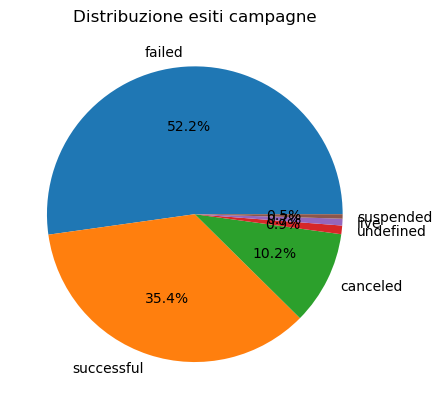

In [6]:
# Distribuzione della variabile target (state)
kickstarter_data['state'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', ylabel='', title='Distribuzione esiti campagne')
plt.show()

### Distribuzione della variabile target (`state`)

**Osservazione:** La maggior parte delle campagne non raggiunge l’obiettivo di finanziamento (`failed`), mentre solo una minoranza ha successo (`successful`).  
**Implicazione:** Il dataset è sbilanciato. Questo sbilanciamento dovrà essere gestito nelle fasi successive (ad esempio tramite tecniche di bilanciamento, scelta di metriche adeguate o ponderazione delle classi) per evitare che il modello sia troppo “conservativo” e tenda a predire sempre la classe maggioritaria.

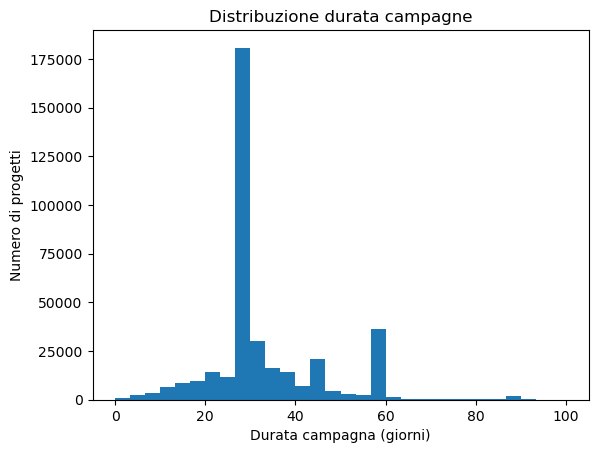

In [7]:
# Istogramma della durata delle campagne
kickstarter_data['duration_days'].plot.hist(bins=30, range=(0, 100))
plt.xlabel('Durata campagna (giorni)')
plt.ylabel('Numero di progetti')
plt.title('Distribuzione durata campagne')
plt.show()

### Istogramma della durata delle campagne (`duration_days`)

**Osservazione:** La durata standard di una campagna Kickstarter è circa 30 giorni, ma esistono campagne con durate fuori dal comune.  
**Implicazione:** Potrebbe essere utile filtrare o trattare come outlier le campagne con durata estremamente breve o lunga, in quanto potrebbero rappresentare errori o casi particolari non generalizzabili.

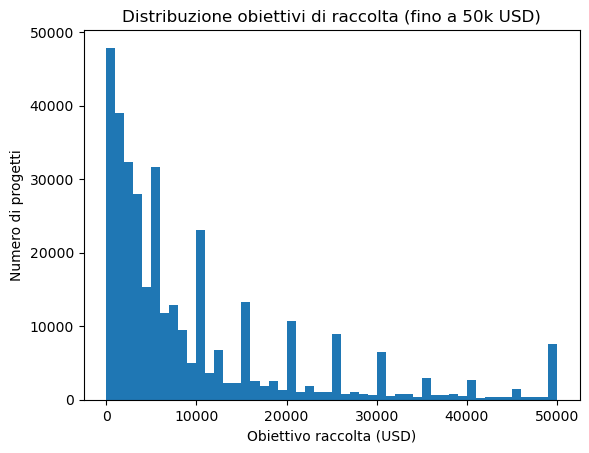

In [8]:
# Istogramma degli obiettivi di raccolta (usd_goal_real)
kickstarter_data['usd_goal_real'].plot.hist(bins=50, range=(0, 50000))
plt.xlabel('Obiettivo raccolta (USD)')
plt.ylabel('Numero di progetti')
plt.title('Distribuzione obiettivi di raccolta (fino a 50k USD)')
plt.show()

### Istogramma degli obiettivi di raccolta (`usd_goal_real`)

**Osservazione:** La distribuzione è fortemente asimmetrica (right-skewed), con una lunga coda di progetti ambiziosi.  
**Implicazione:** Gli outlier potrebbero influenzare negativamente l’addestramento del modello. Potrebbe essere opportuno applicare una trasformazione (ad esempio logaritmica) o escludere i valori estremi.

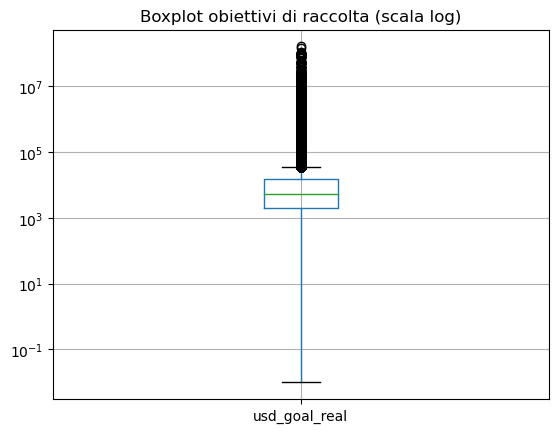

In [9]:
# Boxplot per individuare outlier negli obiettivi di raccolta
kickstarter_data.boxplot(column='usd_goal_real')
plt.yscale('log')
plt.title('Boxplot obiettivi di raccolta (scala log)')
plt.show()

### Boxplot degli obiettivi di raccolta

**Osservazione:** La maggior parte dei progetti si concentra su obiettivi relativamente bassi, mentre pochi puntano a cifre molto elevate.  
**Implicazione:** Anche qui, la presenza di outlier suggerisce la necessità di un trattamento specifico.

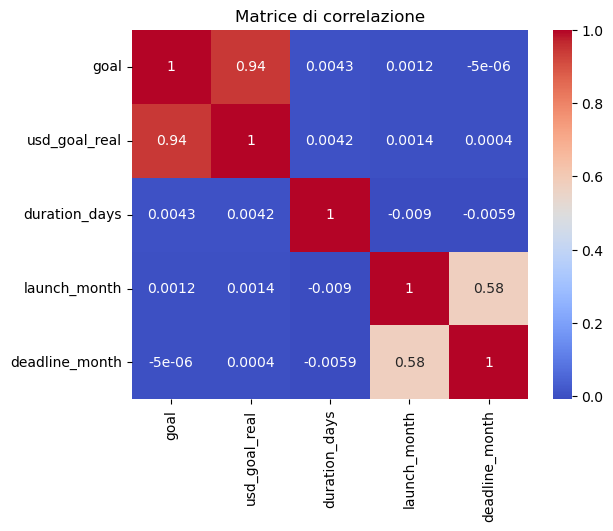

In [10]:
# Matrice di correlazione tra variabili numeriche
import seaborn as sns
corr = kickstarter_data[['goal', 'usd_goal_real', 'duration_days', 'launch_month', 'deadline_month']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matrice di correlazione')
plt.show()

### Matrice di correlazione tra variabili numeriche
 
**Osservazione:** Si nota una forte correlazione tra `goal` e `usd_goal_real` (atteso, dato che rappresentano lo stesso valore in valute diverse). Le altre variabili mostrano correlazioni deboli.  
**Implicazione:** Potrebbe essere ridondante mantenere entrambe le colonne (`goal` e `usd_goal_real`); si può scegliere di tenere solo una delle due. La bassa correlazione tra le altre variabili suggerisce che ciascuna potrebbe apportare informazioni distinte al modello.

In [11]:
kickstarter_data.isnull().any()

name               True
category          False
main_category     False
currency          False
deadline          False
goal              False
launched          False
state             False
country           False
usd_goal_real     False
duration_days     False
launch_month      False
launch_year       False
deadline_month    False
deadline_year     False
dtype: bool

In [12]:
kickstarter_data.isnull().sum()

name              4
category          0
main_category     0
currency          0
deadline          0
goal              0
launched          0
state             0
country           0
usd_goal_real     0
duration_days     0
launch_month      0
launch_year       0
deadline_month    0
deadline_year     0
dtype: int64

### Gestione dei valori nulli

Il controllo dei valori nulli evidenzia che quasi tutte le variabili sono complete, ad eccezione della colonna `name`.  
Di conseguenza, essendo poche, scelgo di rimuovere le righe in cui sono presenti in modo da mantenere un dataset pulito, senza una perdita di dati significativi

In [13]:
kickstarter_data_clean = kickstarter_data.dropna()

## Preparazione dei dati per l’addestramento e la validazione

In questa sezione vengono preparati i dati per l’addestramento e la valutazione dei modelli predittivi.  
Le operazioni principali sono:

- Isolamento della variabile target (`state`) e delle variabili predittive.
- Selezione dei soli progetti con esito "successful" o "failed" per una classificazione binaria.
- Suddivisione del dataset in training set e test set per valutare le prestazioni del modello su dati non visti.
- Applicazione di tecniche di preprocessing, come l’encoding delle variabili categoriche (one-hot encoding) e la gestione dell’eventuale sbilanciamento delle classi (oversampling o undersampling).

In [14]:
features = [
    'name', 'category', 'main_category', 'currency', 'country', 'goal', 'usd_goal_real',
    'duration_days', 'launch_month', 'launch_year', 'deadline_month', 'deadline_year'
]
target = 'state'

feature_set = kickstarter_data[features]
target_set = kickstarter_data[target]

mask = target_set.isin(['successful', 'failed'])
feature_set_final = feature_set[mask]
target_set_final = target_set[mask]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    feature_set_final,
    target_set_final,
    test_size=0.2,
    random_state=42,
    stratify=target_set_final
)

print(f"Training set: {X_train.shape[0]} campioni")
print(f"Test set: {X_test.shape[0]} campioni")

Training set: 265340 campioni
Test set: 66335 campioni


### Suddivisione del dataset in training set e test set

Sono state utilizzate le variabili `feature_set_final` e `target_set_final` per la suddivisione del dataset in training set e test set per i seguenti motivi:

1. **Feature selezionate (`feature_set_final`)**:
    - Contiene solo le variabili predittive rilevanti per il modello, come `category`, `goal`, `usd_goal_real`, `duration_days`, ecc.
    - Sono state escluse variabili non informative o non utilizzabili in fase predittiva, come `ID` o i risultati effettivi della campagna (`pledged`, `state`).
    - Include solo progetti con esito "successful" o "failed", poiché l'obiettivo è una classificazione binaria.

2. **Target (`target_set_final`)**:
    - Contiene la variabile target `state`, limitata alle classi "successful" e "failed".
    - Questo approccio semplifica il problema di classificazione, eliminando altre classi come "canceled" o "live", che non sono rilevanti allo scopo del progetto.

3. **Suddivisione stratificata**:
    - La suddivisione è stata effettuata con il parametro `stratify=target_set_final` per mantenere la stessa proporzione delle classi "successful" e "failed" sia nel training set che nel test set.
    - Questo è importante per evitare sbilanciamenti tra le classi nei set di dati, che potrebbero influenzare negativamente le prestazioni del modello.

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.pipeline import Pipeline

categorical_cols = ["category", "main_category", "currency", "country"]
numeric_cols = ["goal", "usd_goal_real", "duration_days", "launch_month", "launch_year", "deadline_month", "deadline_year"]
text_col = "name"

# Undersampling per classi sbilanciate
train_df = X_train.copy()
train_df["state"] = y_train.values
min_class = train_df["state"].value_counts().idxmin()
n_min = train_df["state"].value_counts().min()
df_balanced = pd.concat([
    train_df[train_df["state"] == min_class],
    resample(train_df[train_df["state"] != min_class], replace=False, n_samples=n_min, random_state=42)
])
X_train_bal = df_balanced.drop(columns="state")
y_train_bal = df_balanced["state"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("txt", TfidfVectorizer(max_features=100), text_col)
])

### Preprocessing e bilanciamento del dataset

In questa sezione sono state svolte le seguenti operazioni:

- **Selezione delle colonne**: sono state individuate le colonne numeriche (`goal`, `usd_goal_real`, `duration_days`, `launch_month`, `launch_year`, `deadline_month`, `deadline_year`), categoriche (`category`, `main_category`, `currency`, `country`) e testuale (`name`) che saranno utilizzate come feature predittive.
- **Gestione dello sbilanciamento delle classi**: dato che la variabile target `state` è sbilanciata (molti più progetti falliti rispetto a quelli di successo), è stato applicato un undersampling della classe maggioritaria nel training set. In questo modo si ottiene un dataset bilanciato che permette al modello di apprendere in modo più equilibrato entrambe le classi.
- **Definizione del preprocessing**: è stato creato un `ColumnTransformer` che applica:
    - la standardizzazione (`StandardScaler`) alle variabili numeriche, per renderle confrontabili e facilitare la convergenza dei modelli;
    - il one-hot encoding (`OneHotEncoder`) alle variabili categoriche, per trasformarle in un formato numerico utilizzabile dai modelli;
    - la vettorizzazione TF-IDF (`TfidfVectorizer`) al nome del progetto, per estrarre informazioni utili dal testo e includerle tra le feature predittive.

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

X_train_bal['name'] = X_train_bal['name'].fillna("")
X_test['name'] = X_test['name'].fillna("")

# Modello 1: Regressione Logistica
logreg_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=500, random_state=42))
])
logreg_pipeline.fit(X_train_bal, y_train_bal)
y_pred_logreg = logreg_pipeline.predict(X_test)

print("Regressione Logistica:")
print(classification_report(y_test, y_pred_logreg))

feature_names = (
    numeric_cols +
    list(logreg_pipeline.named_steps["preproc"].named_transformers_["cat"].get_feature_names_out(categorical_cols)) +
    list(logreg_pipeline.named_steps["preproc"].named_transformers_["txt"].get_feature_names_out())
)
coefs = logreg_pipeline.named_steps["clf"].coef_[0]
coef_df = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)
print("Variabili più rilevanti (LogReg):")
print(coef_df.head(10))

Regressione Logistica:
              precision    recall  f1-score   support

      failed       0.74      0.64      0.69     39544
  successful       0.56      0.67      0.61     26791

    accuracy                           0.65     66335
   macro avg       0.65      0.66      0.65     66335
weighted avg       0.67      0.65      0.66     66335

Variabili più rilevanti (LogReg):
usd_goal_real             -11.185402
goal                       -2.104754
category_Hip-Hop           -1.429899
category_Web               -1.421640
category_Video             -1.406868
category_Apps              -1.402472
category_Residencies        1.388172
category_Tabletop Games     1.386177
category_Photo             -1.363197
category_Mobile Games      -1.324707
dtype: float64



Albero Decisionale:
              precision    recall  f1-score   support

      failed       0.70      0.60      0.65     39544
  successful       0.51      0.63      0.56     26791

    accuracy                           0.61     66335
   macro avg       0.61      0.61      0.60     66335
weighted avg       0.63      0.61      0.61     66335

Variabili più rilevanti (Tree):
usd_goal_real               0.539879
goal                        0.132293
category_Tabletop Games     0.109064
deadline_year               0.070327
duration_days               0.056289
main_category_Music         0.042717
category_Hip-Hop            0.026882
main_category_Publishing    0.017092
category_Video Games        0.002816
launch_year                 0.002641
dtype: float64


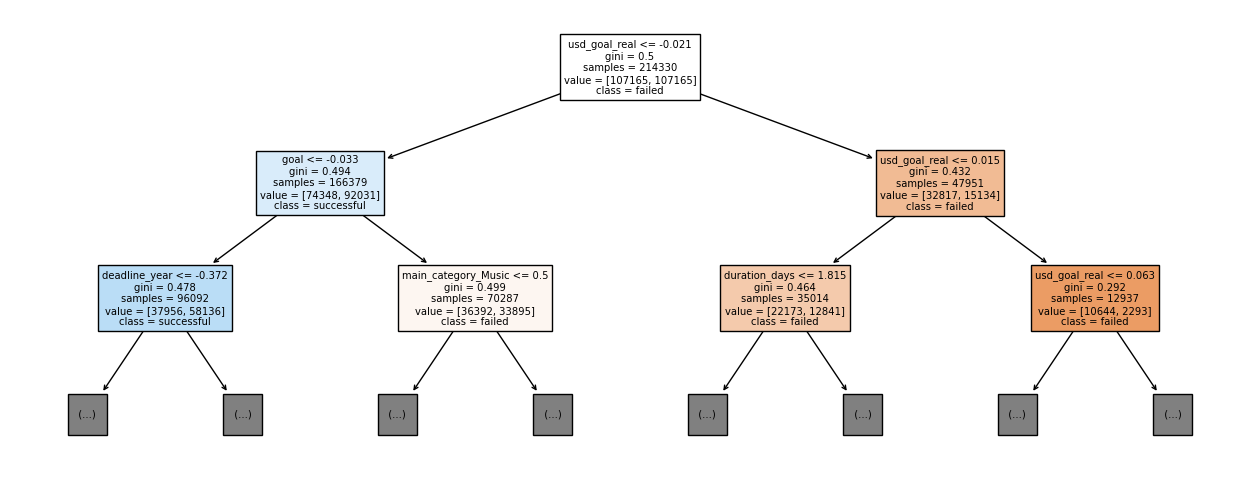

In [18]:
# Modello 2: Albero Decisionale
tree_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", DecisionTreeClassifier(max_depth=4, random_state=42))
])
tree_pipeline.fit(X_train_bal, y_train_bal)
y_pred_tree = tree_pipeline.predict(X_test)

print("\nAlbero Decisionale:")
print(classification_report(y_test, y_pred_tree))

# Analisi importanza variabili nell'albero
importances = tree_pipeline.named_steps["clf"].feature_importances_
importances_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Variabili più rilevanti (Tree):")
print(importances_df.head(10))

plt.figure(figsize=(16, 6))
plot_tree(tree_pipeline.named_steps["clf"], feature_names=feature_names, class_names=tree_pipeline.named_steps["clf"].classes_.tolist(), max_depth=2, filled=True)
plt.show()

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

# Modello 3: Multi-layer Perceptron (MLP)
mlp_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", MLPClassifier(hidden_layer_sizes=(32, 8), activation="relu", max_iter=200, random_state=42))
])
mlp_pipeline.fit(X_train_bal, y_train_bal)
y_pred_mlp = mlp_pipeline.predict(X_test)

print("\nMulti-layer Perceptron (MLP):")
print(classification_report(y_test, y_pred_mlp))

result = permutation_importance(
    mlp_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

preprocessor = mlp_pipeline.named_steps["preproc"]
numeric_features = numeric_cols
categorical_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
text_features = preprocessor.named_transformers_["txt"].get_feature_names_out()

used_feature_names = (
    list(preprocessor.named_transformers_["num"].feature_names_in_) +
    list(preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)) +
    list(preprocessor.named_transformers_["txt"].get_feature_names_out())
)

if len(result.importances_mean) != len(used_feature_names):
    used_feature_names = used_feature_names[:len(result.importances_mean)]

importances_mlp = pd.Series(result.importances_mean, index=used_feature_names).sort_values(ascending=False)

print("Variabili più rilevanti (MLP - permutation importance):")
print(importances_mlp.head(10))


Multi-layer Perceptron (MLP):
              precision    recall  f1-score   support

      failed       0.76      0.63      0.69     39544
  successful       0.56      0.70      0.63     26791

    accuracy                           0.66     66335
   macro avg       0.66      0.67      0.66     66335
weighted avg       0.68      0.66      0.66     66335

Variabili più rilevanti (MLP - permutation importance):
usd_goal_real           0.064545
goal                    0.027067
duration_days           0.026209
category_3D Printing    0.012826
category_Accessories    0.012123
deadline_year           0.012123
category_Animals        0.007655
deadline_month          0.007536
launch_month            0.004212
launch_year             0.002774
dtype: float64


### Confronto tra modelli

Per il problema di classificazione binaria sono stati addestrati e confrontati tre modelli diversi:

1. **Regressione Logistica**  
   Un modello lineare che stima la probabilità di successo della campagna in base alle variabili disponibili. È semplice, interpretabile e fornisce una baseline robusta per problemi di classificazione.

2. **Albero Decisionale**  
   Un modello non lineare che apprende regole decisionali gerarchiche sulle feature per separare le classi. Permette di individuare facilmente le variabili più rilevanti tramite l’analisi della struttura dell’albero e delle importanze delle feature.

3. **Multi-layer Perceptron (MLP)**  
   Una rete neurale artificiale con due strati nascosti, in grado di apprendere relazioni complesse e non lineari tra le variabili. L’importanza delle feature è stata valutata tramite permutation importance, dato che i pesi interni non sono direttamente interpretabili.

Per tutti i modelli è stato:
- Applicato lo stesso preprocessing (standardizzazione delle variabili numeriche, one-hot encoding delle categoriche, vettorizzazione TF-IDF del testo).
- Gestito lo sbilanciamento delle classi tramite undersampling.
- Valutato le performance su un test set separato, utilizzando metriche di classificazione come accuracy, precision, recall e f1-score.
- Analizzato le variabili più rilevanti per ciascun modello, per capire quali caratteristiche influenzano maggiormente la previsione del successo di una campagna Kickstarter.

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

# Pipeline per la regressione logistica
logreg_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "saga"]
}

grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
grid_search.fit(X_train_bal, y_train_bal)

print("Migliori iperparametri (LogisticRegression):", grid_search.best_params_)
print("F1-score (validazione):", grid_search.best_score_)

Migliori iperparametri (LogisticRegression): {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
F1-score (validazione): 0.658890521803242


In [21]:
# Pipeline per Random Forest (alternativa ensemble)
tree_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])

param_grid_tree = {
    "clf__max_depth": [2, 4, 8, 16],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__criterion": ["gini", "entropy"]
}

tree_search = GridSearchCV(
    tree_pipeline,
    param_grid_tree,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)
tree_search.fit(X_train_bal, y_train_bal)

print("Migliori iperparametri (DecisionTree):", tree_search.best_params_)
print("F1-score (validazione):", tree_search.best_score_)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Migliori iperparametri (DecisionTree): {'clf__criterion': 'gini', 'clf__max_depth': 16, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5}
F1-score (validazione): 0.6565921115628823


In [22]:
mlp_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", MLPClassifier(max_iter=200, random_state=42))
])

param_dist = {
    "clf__hidden_layer_sizes": [(32, 8), (64, 16), (32, 32)],
    "clf__activation": ["relu", "tanh"],
    "clf__alpha": [0.0001, 0.001],
    "clf__learning_rate_init": [0.001, 0.01]
}

mlp_search = RandomizedSearchCV(
    mlp_pipeline,
    param_distributions=param_dist,
    n_iter=8,
    cv=2,
    scoring="f1_macro",
    verbose=2,
    random_state=42
)
mlp_search.fit(X_train_bal, y_train_bal)

print("Migliori iperparametri (MLP):", mlp_search.best_params_)
print("F1-score (validazione):", mlp_search.best_score_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


c:\Users\enric\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(64, 16), clf__learning_rate_init=0.001; total time= 2.1min


c:\Users\enric\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(64, 16), clf__learning_rate_init=0.001; total time= 2.1min


c:\Users\enric\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=tanh, clf__alpha=0.0001, clf__hidden_layer_sizes=(32, 32), clf__learning_rate_init=0.001; total time= 1.8min


c:\Users\enric\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=tanh, clf__alpha=0.0001, clf__hidden_layer_sizes=(32, 32), clf__learning_rate_init=0.001; total time= 1.8min


c:\Users\enric\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(32, 8), clf__learning_rate_init=0.001; total time= 1.5min


c:\Users\enric\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(32, 8), clf__learning_rate_init=0.001; total time= 1.5min


c:\Users\enric\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(32, 8), clf__learning_rate_init=0.001; total time= 1.5min


c:\Users\enric\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END clf__activation=tanh, clf__alpha=0.001, clf__hidden_layer_sizes=(32, 8), clf__learning_rate_init=0.001; total time= 1.5min
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(32, 32), clf__learning_rate_init=0.01; total time= 1.2min
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(32, 32), clf__learning_rate_init=0.01; total time= 1.6min
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(64, 16), clf__learning_rate_init=0.01; total time= 2.8min
[CV] END clf__activation=relu, clf__alpha=0.001, clf__hidden_layer_sizes=(64, 16), clf__learning_rate_init=0.01; total time= 2.7min
[CV] END clf__activation=tanh, clf__alpha=0.0001, clf__hidden_layer_sizes=(32, 8), clf__learning_rate_init=0.01; total time= 1.1min
[CV] END clf__activation=tanh, clf__alpha=0.0001, clf__hidden_layer_sizes=(32, 8), clf__learning_rate_init=0.01; total time= 1.0min
[CV] END clf__activation=relu, clf__alpha=0.0001, clf__hidden_layer_sizes=(3

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Nested CV per Regressione Logistica
param_grid_logreg = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "saga"]
}
logreg_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_grid = GridSearchCV(logreg_pipeline, param_grid_logreg, cv=inner_cv, scoring="f1_macro", n_jobs=-1)

nested_scores_logreg = cross_val_score(logreg_grid, X_train_bal, y_train_bal, cv=outer_cv, scoring="f1_macro", n_jobs=-1)
print("Nested CV F1-macro (Logistic Regression): %.3f ± %.3f" % (nested_scores_logreg.mean(), nested_scores_logreg.std()))

# Nested CV per Decision Tree
param_grid_tree = {
    "clf__max_depth": [2, 4, 8, 16],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__criterion": ["gini", "entropy"]
}
tree_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])
tree_grid = GridSearchCV(tree_pipeline, param_grid_tree, cv=inner_cv, scoring="f1_macro", n_jobs=-1)

nested_scores_tree = cross_val_score(tree_grid, X_train_bal, y_train_bal, cv=outer_cv, scoring="f1_macro", n_jobs=-1)
print("Nested CV F1-macro (Decision Tree): %.3f ± %.3f" % (nested_scores_tree.mean(), nested_scores_tree.std()))

Nested CV F1-macro (Logistic Regression): 0.659 ± 0.001
Nested CV F1-macro (Decision Tree): 0.656 ± 0.003


### Validazione annidata (Nested Cross Validation): discussione dei risultati

La nested cross validation consente di ottenere una stima più affidabile delle performance dei modelli, riducendo il rischio di overfitting legato alla scelta degli iperparametri. Questa tecnica è stata applicata sia alla Regressione Logistica che all’Albero Decisionale.

I risultati ottenuti sono i seguenti:

- **Nested CV F1-macro (Logistic Regression):** 0.659 ± 0.001  
- **Nested CV F1-macro (Decision Tree):** 0.656 ± 0.003  

Questi valori indicano che entrambi i modelli presentano prestazioni molto simili in termini di F1-macro, con una variabilità estremamente bassa tra le diverse suddivisioni del dataset. La Regressione Logistica mostra una leggera superiorità, sebbene la differenza sia minima.

In sintesi, la validazione annidata conferma la robustezza delle valutazioni effettuate e dimostra che i modelli selezionati sono in grado di generalizzare efficacemente anche su dati non visti.

In [24]:
# Regressione Logistica ottimizzata
logreg_best = Pipeline([
    ("preproc", preprocessor),
    ("clf", LogisticRegression(
        C=10,
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        random_state=42
    ))
])
logreg_best.fit(X_train_bal, y_train_bal)
y_pred_logreg_best = logreg_best.predict(X_test)
print("Regressione Logistica (ottimizzata):")
print(classification_report(y_test, y_pred_logreg_best))

Regressione Logistica (ottimizzata):
              precision    recall  f1-score   support

      failed       0.74      0.64      0.69     39544
  successful       0.56      0.67      0.61     26791

    accuracy                           0.65     66335
   macro avg       0.65      0.66      0.65     66335
weighted avg       0.67      0.65      0.66     66335



In [25]:
# Albero Decisionale ottimizzato
tree_best = Pipeline([
    ("preproc", preprocessor),
    ("clf", DecisionTreeClassifier(
        criterion="gini",
        max_depth=16,
        min_samples_leaf=1,
        min_samples_split=5,
        random_state=42
    ))
])
tree_best.fit(X_train_bal, y_train_bal)
y_pred_tree_best = tree_best.predict(X_test)
print("\nAlbero Decisionale (ottimizzato):")
print(classification_report(y_test, y_pred_tree_best))


Albero Decisionale (ottimizzato):
              precision    recall  f1-score   support

      failed       0.74      0.65      0.69     39544
  successful       0.56      0.66      0.61     26791

    accuracy                           0.65     66335
   macro avg       0.65      0.65      0.65     66335
weighted avg       0.67      0.65      0.66     66335



In [26]:
# Multi-layer Perceptron ottimizzato
mlp_best = Pipeline([
    ("preproc", preprocessor),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(32, 8),
        activation="relu",
        alpha=0.0001,
        learning_rate_init=0.001,
        max_iter=200,
        random_state=42
    ))
])
mlp_best.fit(X_train_bal, y_train_bal)
y_pred_mlp_best = mlp_best.predict(X_test)
print("\nMulti-layer Perceptron (MLP) ottimizzato:")
print(classification_report(y_test, y_pred_mlp_best))


Multi-layer Perceptron (MLP) ottimizzato:
              precision    recall  f1-score   support

      failed       0.76      0.63      0.69     39544
  successful       0.56      0.70      0.63     26791

    accuracy                           0.66     66335
   macro avg       0.66      0.67      0.66     66335
weighted avg       0.68      0.66      0.66     66335



### Confronto tra modelli: risultati finali e scelta del modello per la web app

Dopo la ricerca degli iperparametri, i tre modelli sono stati riaddestrati e valutati sul test set. I risultati ottenuti sono i seguenti:

- **Regressione Logistica (ottimizzata):**
  - F1-score classe "successful": **0.61**
  - Recall classe "successful": **0.67**
  - Accuracy complessiva: **0.65**

- **Albero Decisionale (ottimizzato):**
  - F1-score classe "successful": **0.61**
  - Recall classe "successful": **0.66**
  - Accuracy complessiva: **0.65**

- **Multi-layer Perceptron (MLP) ottimizzato:**
  - F1-score classe "successful": **0.63**
  - Recall classe "successful": **0.70**
  - Accuracy complessiva: **0.66**

Tutti i modelli mostrano prestazioni simili in termini di accuratezza e F1-score macro, ma il **Multi-layer Perceptron (MLP)** ottiene il valore più alto sia di F1-score che di recall sulla classe "successful", che rappresenta l'obiettivo principale della web app (identificare i progetti di successo).

**Per questo motivo, il modello scelto per la web app è il Multi-layer Perceptron (MLP)**, in quanto garantisce una maggiore capacità di individuare i progetti potenzialmente vincenti, offrendo così un supporto più efficace agli utenti interessati a lanciare una campagna Kickstarter di successo.